## Import libraries

In [37]:
# libraries for data analysis.
import pandas as pd
import numpy as np
import pickle
import networkx as nx
from sklearn.preprocessing import MinMaxScaler

# libraries for depicting graphs.
import matplotlib.pyplot as plt
import nxviz 
import seaborn as sns
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Ellipse

## Load the data of nodes & edges for analysis:

In [2]:
node_infodf = pd.read_hdf('panama_nodes.h5', 'df')
edge_pd = pd.read_hdf("panama_edges.h5", 'df')
node_infodf.head()

,node_id,name,country_codes,countries,type,New_node_ID,degrees,subgraph
0,10000001,"TIANSHENG INDUSTRY AND TRADING CO., LTD.",HKG,Hong Kong,entity,490056,3,1
1,10000002,"NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.",HKG,Hong Kong,entity,515866,3,1
2,10000003,"HOTFOCUS CO., LTD.",HKG,Hong Kong,entity,415563,4,1
3,10000004,"SKY-BLUE GIFTS & TOYS CO., LTD.",HKG,Hong Kong,entity,9965,3,1
4,10000005,FORTUNEMAKER INVESTMENTS CORPORATION,HKG,Hong Kong,entity,35677,2,2791


## 1. Nodes analysis

In [21]:
# check the distributions of nodes by their types:
node_infodf.groupby("type")[['node_id']].count().sort_values("node_id", ascending=False)\
.reset_index().rename(columns={"node_id":"count"})

,type,count
0,officer,238283
1,entity,213634
2,address,93442
3,intermediary,14074


In [25]:
# Check the top 10 nodes that have the highest degress:
node_infodf.nlargest(10, 'degrees')[["name","degrees"]]

,name,degrees
547246,ORION HOUSE SERVICES (HK) LIMITED,7016
557352,MOSSACK FONSECA & CO.,4364
557529,PRIME CORPORATE SOLUTIONS SARL,4117
547212,OFFSHORE BUSINESS CONSULTANT (INT'L) LIMITED,4094
553521,MOSSACK FONSECA & CO. (SINGAPORE) PTE LTD.,3888
466661,MOSSFON SUBSCRIBERS LTD.,3883
554841,CONSULCO INTERNATIONAL LIMITED,3168
552859,MOSSACK FONSECA & CO. (GENEVA) S.A.,2986
557033,MOSSACK FONSECA & CO. (U.K.) LIMITED,2538
554635,MOSSACK FONSECA & CO. (PERU) CORP.,2055


In [11]:
# Check the top 15 countries that have the highest number of nodes:
node_infodf.groupby("countries")[['node_id']].count().sort_values("node_id", ascending=False)\
.iloc[0:15,].reset_index().rename(columns={"node_id":"count"})

,countries,count
0,unknown,96672
1,Hong Kong,62622
2,China,48368
3,Switzerland,46218
4,Jersey,24075
5,Panama,23939
6,United Kingdom,19889
7,British Virgin Islands,15834
8,Luxembourg,13658
9,Guernsey,12269


Top 5 countries types are: Hong Kong, China, Switzerland, Jersey, Panama


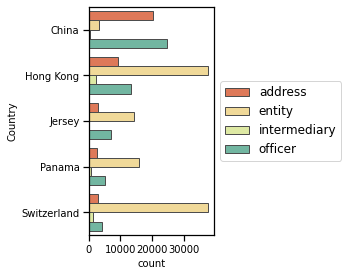

In [16]:
topcountries = node_infodf.groupby("countries")[['node_id']].count().sort_values("node_id", ascending=False).iloc[1:6,]
print("Top 5 countries types are:", ", ".join([x for x in topcountries.index]))

topnodes_classify = node_infodf[node_infodf.countries.isin(topcountries.index)].groupby(
    ["countries", 'type'])[['node_id']].count().reset_index().rename(columns={'node_id':'count', 'countries':'Country'})


sns.set_context("notebook",rc={"xtick.labelsize":10,"ytick.labelsize":10, 
                             "legend.fontsize":"medium",
                             "axes.titlesize":10,"axes.labelsize":10})
fig, ax =  plt.subplots(figsize=(5,4))
sns.barplot(x="count", hue="type", y="Country",
            palette="Spectral", edgecolor=".3", ax = ax,
            data=topnodes_classify);
sns.axes_style({'axes.grid': True,'grid.color': '.8', 'grid.linestyle': '-',})
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
fig.savefig("Graphs/Panama_topnodes.png", dpi=300)

# 2. Edges analysis

In [27]:
# Check Edges
print(edge_pd.groupby('link').count()[['Source']].sort_values('Source', ascending =False).shape)
edge_pd.groupby('link').count()[['Source']].sort_values('Source', ascending =False).head(5)

(33, 1)


,Source
link,
shareholder of,293961
intermediary of,213634
registered address,151105
beneficiary of,15150
beneficial owner of,79


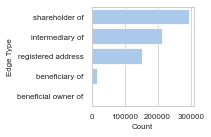

In [28]:
# Check the top 5 edges:
data = edge_pd.groupby('link').count()[['Source']].sort_values('Source', ascending =False).head(5).reset_index()
data = data.rename(columns={'Source':'Count', 'link':'Edge Type'})

sns.set(style="whitegrid")
sns.set_color_codes("pastel")
sns.set_context("paper", rc={"xtick.labelsize":8,"ytick.labelsize":8, 
                             "axes.titlesize":8,"axes.labelsize":8})   
f, ax = plt.subplots(figsize=(3, 2))
sns.barplot(x="Count", y="Edge Type",ax=ax, data=data, color="b")
f.tight_layout()
f.savefig("Graphs/Panama_edge_bars.png", dpi=300)

## 3. Component analysis.

In [29]:
# Networkx is used to lable 
undirectedG = nx.Graph()
undirectedG.add_edges_from(edge_pd[['Source','Target']].to_numpy())
ccsubgraphs = sorted(nx.connected_components(undirectedG), key=len, reverse=True)
len(ccsubgraphs)

11043

In [31]:
# Calculate the number of nodes in every component.
nodes_subgraph = node_infodf.groupby('subgraph')[
        ['node_id']].count().reset_index().rename(columns={'node_id':'counts'})
nodes_subgraph.head()

,subgraph,counts
0,1,455479
1,2,2995
2,3,730
3,4,644
4,5,597


In [32]:
# calculate the number of different components.
x, y = [], []
for i in range(1, 1000):
    rows = nodes_subgraph[nodes_subgraph.counts==i].shape[0]
    if rows > 0:
        x.append(rows)
        y.append(i)
    else:
        continue
x.append(1); y.append(2995)
x.append(1); y.append(455479)

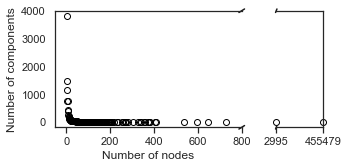

In [34]:
# draw scatter of number of components vs number of nodes:
sns.set(style="white")

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize=(5,2.5), 
                              gridspec_kw={'width_ratios': [4, 1]})

marker_style = dict(color='black',fillstyle='none')
ax.plot(y, x, marker="o", **marker_style, linewidth=0,)
ax2.plot([2995, 455479],[1,1], marker="o", **marker_style, linewidth=0,clip_on=False)
ax2.set_clip_on(False)

ax.set_xlim(-50, 800) 
ax2.set_xlim((2995, 455479))
ax.set_ylim(-200, 4000)
ax2.set_xticks((2995, 455479))

ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.xaxis.tick_bottom()
ax2.tick_params(left=False) 
ax2.xaxis.tick_bottom()


d = .015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((-d, +d), (-d, +d), **kwargs)       
ax2.plot(( - d, + d), (1-d, 1+d), **kwargs) 

kwargs.update(transform=ax.transAxes)
ax.plot((1-d,1 +d), ( - d,  + d), **kwargs)  
ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  

ax.set_xlabel('Number of nodes')
ax.set_ylabel('Number of components')
fig.tight_layout()
fig.savefig("Graphs/Type_components_counts.png", dpi=150)

### Inspect the third largest component

In [ ]:
# Extract the nodes and edges of thethird largest component with 730 nodes for graph-tools:
# The final outputs are two numpy arrarys that contain edges and nodes information, which will be used
# as the input for the graph-tools, please refer to the python script for the final depicting of networks.

fordraw_nodes = node_infodf[node_infodf.subgraph==3].sort_values("degrees", ascending =False).copy()
fordraw_edges = edge_pd[edge_pd.Source.isin(fordraw_nodes.New_node_ID) |
                        edge_pd.Target.isin(fordraw_nodes.New_node_ID)]

fordraw_nodes = fordraw_nodes.sort_values("degrees", ascending =False)
fordraw_nodes = fordraw_nodes.reset_index(drop=True).reset_index()
dict_nodes =  dict(zip(fordraw_nodes.New_node_ID, range(fordraw_nodes.index[-1]+1))) # for graph-tool

fordraw_edges['Source_draw'] = fordraw_edges['Source'].map(dict_nodes)
fordraw_edges['Target_draw'] = fordraw_edges['Target'].map(dict_nodes)
fordraw_edges['Source_country'] = fordraw_edges['Source_draw'].map(fordraw_nodes[ 'countries'].to_dict())
fordraw_edges['Target_country'] = fordraw_edges['Target_draw'].map(fordraw_nodes[ 'countries'].to_dict())

print(fordraw_edges.shape, set(fordraw_edges.link), set(fordraw_nodes.type))

alpha = 0.8
nodecolordict = {'entity':[0.976, 0.203, 0.435, alpha] , 
                 'address':[0.835, 0.698, 0.921, alpha],
                 'intermediary':[0.9, 0.603, 0.019, alpha], 
                'officer':[0.203, 0.976, 0.823,alpha]}

fordraw_nodes['color_bytype'] = fordraw_nodes['type'].map(nodecolordict)

np.save("Input/Component730nodes.npy",fordraw_nodes[['index','name', 'country_codes', 'countries',
                                                    'type', 'degrees', 'color_bytype']].to_numpy())
np.save("Input/Component730nodes_sfdp_edges.npy",fordraw_edges[['Source_draw', 'Target_draw',
                                                              'link',]].to_numpy())


In [40]:
# Calculate the connections between different countries:
Countries = fordraw_nodes.groupby("countries")[['index']].count().reset_index().countries
# Load the longitude and latitudes of different countries:
countries_loc = pd.read_csv("Input/Countries_csv.csv");

# prepare the data for drawing the connections on the map:
Geoconnection = fordraw_edges.groupby(["Source_country","Target_country","link"])['START_ID'].count().reset_index()

# Use the degrees of edges into their width. 
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(Geoconnection[['START_ID']])
Geoconnection['width'] = scaled_values
Geoconnection['width'] = Geoconnection['width']*3 +2
Geoconnection['width'].max(), Geoconnection['width'].min()

# Use the degrees of self-loop edges into their radius, as they were depicted as circles.
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(Geoconnection[['START_ID']])
Geoconnection['size'] = scaled_values
Geoconnection['size'] = Geoconnection['size']*2 +0.5
Geoconnection['size'].max(), Geoconnection['size'].min()

circles = Geoconnection[Geoconnection.Source_country == Geoconnection.Target_country].reset_index(drop=True)
color_edge_dict={"intermediary of":[0.980, 0.921, 0.2,], # yellow
                 "shareholder of":[0.478, 0.482, 1, ], #purple
                 "beneficiary of":[.5, .5, .5, ],
                 "registered address":[0.882, 0.443, 0.996,] # pinkish
                 }
# Annotate the countries by their name:
lons = countries_loc.loc[countries_loc.name.isin(Countries), 'longitude']
lats = countries_loc.loc[countries_loc.name.isin(Countries), 'latitude']
countries_list = countries_loc.loc[countries_loc.name.isin(Countries), 'name']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


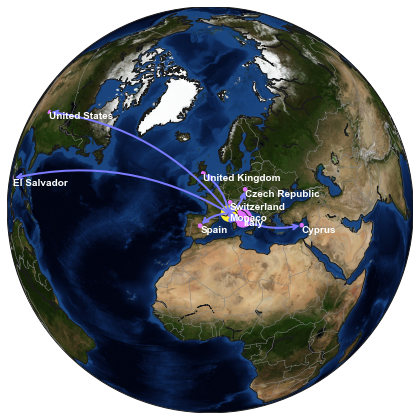

In [42]:
# Draw the connections between countries on the orthographic map.

fig=plt.figure(figsize=(6, 6) )

map = Basemap(projection='ortho', lat_0=45, lon_0=0,)
map.bluemarble()
map.drawcoastlines()
map.drawcountries(color="grey")

for i in range(0, 20):
    [x1, y1] = countries_loc.loc[countries_loc.name == Geoconnection.loc[i,'Source_country'], 
                               ['longitude', 'latitude']].values[0]
    [x2, y2] = countries_loc.loc[countries_loc.name == Geoconnection.loc[i,'Target_country'], 
                               ['longitude', 'latitude']].values[0]
    lcolor = color_edge_dict[Geoconnection.loc[i,'link']]
    width = round(Geoconnection.loc[i,'width'], 2)
    
    plt.annotate('', xy=map(x1, y1),  xycoords='data',
                    xytext=map(x2, y2), textcoords='data',
                    arrowprops=dict(arrowstyle="->", color=lcolor, lw=width, #alpha=.6, #fc=color,ec='none', patchB=el,
                                connectionstyle="arc3,rad=.2"),  
                    )
for i in range(0, circles.shape[0]):
    [x1, y1] = countries_loc.loc[countries_loc.name == circles.loc[i,'Source_country'], 
                               ['longitude', 'latitude']].values[0]
    ccolor = color_edge_dict[circles.loc[i,'link']]
    size = round(circles.loc[i,'size'], 2)
    map.tissot(x1, y1, size, 50, color =ccolor)

x, y = map(list(lons), list(lats))
for i, label in enumerate(countries_list):
    plt.text(x[i], y[i], label,fontsize=10, fontweight='bold',
                    ha='left', va='top',color='white',)

fig.tight_layout()
#fig.savefig("730_countries_connection.png", dpi=150)
plt.show()